# Uncover Music Recommendation System on Spotify

Presenters: Team 6

Andrew Rafael James,
Doris Liang,
Hunter Guo,
Monica Ko,
Pang Leesuravanich


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import normalize
from scipy.spatial.distance import euclidean
from scipy.sparse import hstack

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

# !pip install rake_nltk
from rake_nltk import Rake

%matplotlib inline

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sirindalee/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sirindalee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sirindalee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Dataset

In [3]:
pd.set_option("display.max_columns", None)
# pd.set_option("display.max_colwidth", None)

df = pd.read_csv("spotify_clean_dataset_with_lyrics.csv")
cluster = pd.read_csv("kmeans_4_clusters.csv")

In [4]:
df = df.iloc[:, 1:]

In [5]:
df.head()

,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album Release Date,Album Image URL,Disc Number,Track Number,Track Duration (ms),Track Preview URL,Explicit,Popularity,ISRC,Added By,Added At,Artist Genres,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Label,Copyrights,lyrics
0,spotify:track:0vNPJrUrBnMFdCs8b2MTNG,Fader,spotify:artist:4W48hZAnAHVOC2c8WH8pcq,The Temper Trap,spotify:album:0V59MMtgoruvEqMv18KAOH,Conditions (Tour Edition),spotify:artist:4W48hZAnAHVOC2c8WH8pcq,The Temper Trap,2009,https://i.scdn.co/image/ab67616d0000b273f86ae8...,1,6,192373,https://p.scdn.co/mp3-preview/14264bd1501d2723...,False,0,GBZUZ0900014,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"indietronica,modern rock,shimmer pop",0.532,0.760,11.0,-7.123,0.0,0.0353,0.000101,0.690000,0.0752,0.158,134.974,4.0,Liberation Records,"C 2010 Liberation Music, P 2010 Liberation Music","I'm in transit\n Floating, stranded on this bo..."
1,spotify:track:0NpvdCO506uO58D4AbKzki,Sherry,spotify:artist:6mcrZQmgzFGRWf7C0SObou,Frankie Valli & The Four Seasons,spotify:album:0NUEQILaBzavnzcMEs4buZ,The Very Best of Frankie Valli & The 4 Seasons,spotify:artist:6mcrZQmgzFGRWf7C0SObou,Frankie Valli & The Four Seasons,2003-01-14,https://i.scdn.co/image/ab67616d0000b273b96c21...,1,1,152160,https://p.scdn.co/mp3-preview/e3f765262ebc349e...,False,54,USRH10175197,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"adult standards,bubblegum pop,doo-wop,lounge,n...",0.703,0.478,7.0,-8.062,1.0,0.0441,0.626000,0.000000,0.1130,0.734,117.562,4.0,Rhino,C © 2004 Bob Gaudio & Frankie Valli d/b/a The ...,"Sherry, Sherry baby\n Sherry, Sherry baby\n Sh..."
2,spotify:track:1MtUq6Wp1eQ8PC6BbPCj8P,I Took A Pill In Ibiza - Seeb Remix,"spotify:artist:2KsP6tYLJlTBvSUxnwlVWa, spotify...","Mike Posner, Seeb",spotify:album:1Tz3Ai1guEFf4hV3d9i17K,"At Night, Alone.",spotify:artist:2KsP6tYLJlTBvSUxnwlVWa,Mike Posner,2016-05-06,https://i.scdn.co/image/ab67616d0000b273a19be7...,1,13,197933,https://p.scdn.co/mp3-preview/7bae6aac6d699135...,True,63,USUM71509342,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"dance pop,pop,pop dance,pop rap,pop dance",0.664,0.714,7.0,-6.645,0.0,0.1110,0.035300,0.000008,0.0843,0.710,101.969,4.0,"Monster Mountain, LLC / Island","C © 2016 Island Records, a division of UMG Rec...",NaN
3,spotify:track:59lq75uFIqzUZcgZ4CbqFG,Let Go for Tonight,spotify:artist:7qRll6DYV06u2VuRPAVqug,Foxes,spotify:album:5AQ7uKRSpAv7SNUl4j24ru,Glorious (Deluxe),spotify:artist:7qRll6DYV06u2VuRPAVqug,Foxes,2014-05-12,https://i.scdn.co/image/ab67616d0000b273ae5c7d...,1,5,238413,https://p.scdn.co/mp3-preview/84a003d72f9f1468...,False,39,GBARL1301249,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"electropop,metropopolis,uk pop",0.543,0.808,9.0,-6.615,0.0,0.0632,0.042900,0.000002,0.3260,0.299,140.064,4.0,Sign Of The Times Records,P (P) 2014 Sign Of The Times Limited under exc...,Fell from the sky\n We fell from the sky and s...
4,spotify:track:7KdcZQ3GJeGdserhK61kfv,The Way I Want To Touch You,spotify:artist:7BEfMxbaqx6dOpbtlEqScm,Captain & Tennille,spotify:album:3GUxesVyOehInaxJyCTh6d,Love Will Keep Us Together,spotify:artist:7BEfMxbaqx6dOpbtlEqScm,Captain & Tennille,1975-01-01,https://i.scdn.co/image/ab67616d0000b273e21a28...,1,3,163586,https://p.scdn.co/mp3-preview/9e7a4a7b7dc56dc3...,False,35,USAM10110025,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"mellow gold,soft rock,yacht rock",0.664,0.585,0.0,-7.062,0.0,0.0248,0.624000,0.000112,0.3430,0.597,111.290,4.0,A&M,"C © 1975 A&M Records, P This Compilation ℗ 197...","I never wanted, I never wanted to touch a man\..."


In [6]:
cluster.head()

,Unnamed: 0,Track Name,Track URI,Artist Name(s),Artist Genres,Album Name,Album Release Date,Popularity,Cluster,Track Characteristics
0,0,Fader,spotify:track:0vNPJrUrBnMFdCs8b2MTNG,The Temper Trap,"indietronica,modern rock,shimmer pop",Conditions (Tour Edition),2009,0,3,Instrumental & Pure Music
1,1,Sherry,spotify:track:0NpvdCO506uO58D4AbKzki,Frankie Valli & The Four Seasons,"adult standards,bubblegum pop,doo-wop,lounge,n...",The Very Best of Frankie Valli & The 4 Seasons,2003-01-14,54,2,Acoustic & Quiet
2,2,I Took A Pill In Ibiza - Seeb Remix,spotify:track:1MtUq6Wp1eQ8PC6BbPCj8P,"Mike Posner, Seeb","dance pop,pop,pop dance,pop rap,pop dance","At Night, Alone.",2016-05-06,63,0,Danceable & Vocal
3,3,Let Go for Tonight,spotify:track:59lq75uFIqzUZcgZ4CbqFG,Foxes,"electropop,metropopolis,uk pop",Glorious (Deluxe),2014-05-12,39,1,Energetic & Electric
4,4,The Way I Want To Touch You,spotify:track:7KdcZQ3GJeGdserhK61kfv,Captain & Tennille,"mellow gold,soft rock,yacht rock",Love Will Keep Us Together,1975-01-01,35,2,Acoustic & Quiet


In [7]:
df = df.merge(cluster[['Track Name', 'Artist Name(s)', 'Artist Genres', 'Album Name', 'Album Release Date', 'Cluster', 'Track Characteristics']],
         on = ['Track Name', 'Artist Name(s)', 'Artist Genres', 'Album Name', 'Album Release Date']).drop_duplicates()

In [8]:
df.head()

,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album Release Date,Album Image URL,Disc Number,Track Number,Track Duration (ms),Track Preview URL,Explicit,Popularity,ISRC,Added By,Added At,Artist Genres,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Label,Copyrights,lyrics,Cluster,Track Characteristics
0,spotify:track:0vNPJrUrBnMFdCs8b2MTNG,Fader,spotify:artist:4W48hZAnAHVOC2c8WH8pcq,The Temper Trap,spotify:album:0V59MMtgoruvEqMv18KAOH,Conditions (Tour Edition),spotify:artist:4W48hZAnAHVOC2c8WH8pcq,The Temper Trap,2009,https://i.scdn.co/image/ab67616d0000b273f86ae8...,1,6,192373,https://p.scdn.co/mp3-preview/14264bd1501d2723...,False,0,GBZUZ0900014,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"indietronica,modern rock,shimmer pop",0.532,0.760,11.0,-7.123,0.0,0.0353,0.000101,0.690000,0.0752,0.158,134.974,4.0,Liberation Records,"C 2010 Liberation Music, P 2010 Liberation Music","I'm in transit\n Floating, stranded on this bo...",3,Instrumental & Pure Music
1,spotify:track:0NpvdCO506uO58D4AbKzki,Sherry,spotify:artist:6mcrZQmgzFGRWf7C0SObou,Frankie Valli & The Four Seasons,spotify:album:0NUEQILaBzavnzcMEs4buZ,The Very Best of Frankie Valli & The 4 Seasons,spotify:artist:6mcrZQmgzFGRWf7C0SObou,Frankie Valli & The Four Seasons,2003-01-14,https://i.scdn.co/image/ab67616d0000b273b96c21...,1,1,152160,https://p.scdn.co/mp3-preview/e3f765262ebc349e...,False,54,USRH10175197,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"adult standards,bubblegum pop,doo-wop,lounge,n...",0.703,0.478,7.0,-8.062,1.0,0.0441,0.626000,0.000000,0.1130,0.734,117.562,4.0,Rhino,C © 2004 Bob Gaudio & Frankie Valli d/b/a The ...,"Sherry, Sherry baby\n Sherry, Sherry baby\n Sh...",2,Acoustic & Quiet
2,spotify:track:1MtUq6Wp1eQ8PC6BbPCj8P,I Took A Pill In Ibiza - Seeb Remix,"spotify:artist:2KsP6tYLJlTBvSUxnwlVWa, spotify...","Mike Posner, Seeb",spotify:album:1Tz3Ai1guEFf4hV3d9i17K,"At Night, Alone.",spotify:artist:2KsP6tYLJlTBvSUxnwlVWa,Mike Posner,2016-05-06,https://i.scdn.co/image/ab67616d0000b273a19be7...,1,13,197933,https://p.scdn.co/mp3-preview/7bae6aac6d699135...,True,63,USUM71509342,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"dance pop,pop,pop dance,pop rap,pop dance",0.664,0.714,7.0,-6.645,0.0,0.1110,0.035300,0.000008,0.0843,0.710,101.969,4.0,"Monster Mountain, LLC / Island","C © 2016 Island Records, a division of UMG Rec...",NaN,0,Danceable & Vocal
3,spotify:track:59lq75uFIqzUZcgZ4CbqFG,Let Go for Tonight,spotify:artist:7qRll6DYV06u2VuRPAVqug,Foxes,spotify:album:5AQ7uKRSpAv7SNUl4j24ru,Glorious (Deluxe),spotify:artist:7qRll6DYV06u2VuRPAVqug,Foxes,2014-05-12,https://i.scdn.co/image/ab67616d0000b273ae5c7d...,1,5,238413,https://p.scdn.co/mp3-preview/84a003d72f9f1468...,False,39,GBARL1301249,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"electropop,metropopolis,uk pop",0.543,0.808,9.0,-6.615,0.0,0.0632,0.042900,0.000002,0.3260,0.299,140.064,4.0,Sign Of The Times Records,P (P) 2014 Sign Of The Times Limited under exc...,Fell from the sky\n We fell from the sky and s...,1,Energetic & Electric
4,spotify:track:7KdcZQ3GJeGdserhK61kfv,The Way I Want To Touch You,spotify:artist:7BEfMxbaqx6dOpbtlEqScm,Captain & Tennille,spotify:album:3GUxesVyOehInaxJyCTh6d,Love Will Keep Us Together,spotify:artist:7BEfMxbaqx6dOpbtlEqScm,Captain & Tennille,1975-01-01,https://i.scdn.co/image/ab67616d0000b273e21a28...,1,3,163586,https://p.scdn.co/mp3-preview/9e7a4a7b7dc56dc3...,False,35,USAM10110025,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"mellow gold,soft rock,yacht rock",0.664,0.585,0.0,-7.062,0.0,0.0248,0.624000,0.000112,0.3430,0.597,111.290,4.0,A&M,"C © 1975 A&M Records, P This Compilation ℗ 197...","I never wanted, I never wanted to touch a man\...",2,Acoustic & Quiet


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9966 entries, 0 to 10554
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Track URI              9966 non-null   object 
 1   Track Name             9966 non-null   object 
 2   Artist URI(s)          9966 non-null   object 
 3   Artist Name(s)         9966 non-null   object 
 4   Album URI              9966 non-null   object 
 5   Album Name             9966 non-null   object 
 6   Album Artist URI(s)    9966 non-null   object 
 7   Album Artist Name(s)   9966 non-null   object 
 8   Album Release Date     9966 non-null   object 
 9   Album Image URL        9966 non-null   object 
 10  Disc Number            9966 non-null   int64  
 11  Track Number           9966 non-null   int64  
 12  Track Duration (ms)    9966 non-null   int64  
 13  Track Preview URL      9966 non-null   object 
 14  Explicit               9966 non-null   bool   
 15  Populari

In [10]:
df['Popularity'].describe()

count    9966.000000
mean       32.476018
std        27.506747
min         0.000000
25%         0.000000
50%        34.000000
75%        57.000000
max        94.000000
Name: Popularity, dtype: float64

In [11]:
df[df['Popularity'] == 0]

,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album Release Date,Album Image URL,Disc Number,Track Number,Track Duration (ms),Track Preview URL,Explicit,Popularity,ISRC,Added By,Added At,Artist Genres,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Label,Copyrights,lyrics,Cluster,Track Characteristics
0,spotify:track:0vNPJrUrBnMFdCs8b2MTNG,Fader,spotify:artist:4W48hZAnAHVOC2c8WH8pcq,The Temper Trap,spotify:album:0V59MMtgoruvEqMv18KAOH,Conditions (Tour Edition),spotify:artist:4W48hZAnAHVOC2c8WH8pcq,The Temper Trap,2009,https://i.scdn.co/image/ab67616d0000b273f86ae8...,1,6,192373,https://p.scdn.co/mp3-preview/14264bd1501d2723...,False,0,GBZUZ0900014,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"indietronica,modern rock,shimmer pop",0.532,0.760,11.0,-7.123,0.0,0.0353,0.000101,0.690000,0.0752,0.158,134.974,4.0,Liberation Records,"C 2010 Liberation Music, P 2010 Liberation Music","I'm in transit\n Floating, stranded on this bo...",3,Instrumental & Pure Music
19,spotify:track:5ma71INSTL8sY1HzjVBj2g,Riptide,spotify:artist:10exVja0key0uqUkk6LJRT,Vance Joy,spotify:album:1TIkCvpgUWCpjKOuMVaGZD,Dream Your Life Away,spotify:artist:10exVja0key0uqUkk6LJRT,Vance Joy,2014-09-05,https://i.scdn.co/image/ab67616d0000b273bcf5a4...,1,4,201733,https://p.scdn.co/mp3-preview/d2a7f46a047a5713...,False,0,AULI01385760,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"folk-pop,modern rock",0.502,0.719,1.0,-6.649,1.0,0.0349,0.460000,0.000000,0.1140,0.438,101.609,4.0,Liberation Records,"C 2014 Liberation Music, P 2014 Liberation Music",I was scared of dentists and the dark\n I was ...,2,Acoustic & Quiet
23,spotify:track:2RiJYFyzmE4a5xYV7n7sgI,Should’ve Been Us,spotify:artist:1vSN1fsvrzpbttOYGsliDr,Tori Kelly,spotify:album:7cd41qBONvfjaQI6r8MCGp,Unbreakable Smile,spotify:artist:1vSN1fsvrzpbttOYGsliDr,Tori Kelly,2015-06-23,https://i.scdn.co/image/ab67616d0000b273813b12...,1,5,186477,https://p.scdn.co/mp3-preview/e81eff876738b140...,False,0,USUM71505910,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"pop,post-teen pop",0.650,0.766,6.0,-5.443,0.0,0.1190,0.004080,0.000007,0.0759,0.467,89.974,4.0,EMI Recorded Music Australia Pty Ltd,C (C) 2015 Capitol Records & Schoolboy Records...,Walk around with my head down\n But I can't hi...,0,Danceable & Vocal
28,spotify:track:656xZ2pwfA1J59EMussJOK,No Secrets,spotify:artist:2PeqTZKroEc2oDwTfmB2al,The Angels,spotify:album:6WWq4QGRPcBEWpeB9w4qJR,Greatest Hits,spotify:artist:2PeqTZKroEc2oDwTfmB2al,The Angels,2011-10-28,https://i.scdn.co/image/ab67616d0000b273826a43...,1,10,258959,https://p.scdn.co/mp3-preview/079d5ca7ad61eaa8...,False,0,AULI00515860,spotify:user:bradnumber1,2021-08-08T09:26:31Z,australian rock,0.445,0.719,7.0,-5.147,1.0,0.0285,0.000163,0.000008,0.2170,0.551,142.020,4.0,Bloodlines,"C 2011 Bloodlines, P 2011 Bloodlines",Amanda the actress waits at the station\n She'...,1,Energetic & Electric
31,spotify:track:5qnqVH96GFq3Qo71lEkFT5,Saturday Sun,spotify:artist:10exVja0key0uqUkk6LJRT,Vance Joy,spotify:album:3S9ZdKgCTuobkoIWUK2gH0,Nation of Two,spotify:artist:10exVja0key0uqUkk6LJRT,Vance Joy,2018-02-23,https://i.scdn.co/image/ab67616d0000b2730301c4...,1,4,214746,https://p.scdn.co/mp3-preview/47204eb241dee5c5...,False,0,USAT21705384,spotify:user:bradnumber1,2021-08-08T09:26:31Z,"folk-pop,modern rock",0.628,0.869,8.0,-4.339,1.0,0.0489,0.497000,0.000000,0.1690,0.701,99.970,4.0,Liberation Records,"C 2018 Liberation Records, P 2018 Liberation R...","Oh, Saturday Sun\n I met someone\n Out on the ...",0,Danceable & Vocal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10532,spotify:track:67I8eELvVMS1zfEGfbM0uc,Somebody Loves You,spotify:artist:0t3QQl52F463sxGXb1ckhB,Betty Who,spotify:album:17xYStCnOWF5AjhzWY4vCY,Somebody Loves You,spotify:artist:0t3QQl52F463sxGXb1ckhB,Betty Who,2012-12-

In [12]:
df.isnull().sum()

Track URI                   0
Track Name                  0
Artist URI(s)               0
Artist Name(s)              0
Album URI                   0
Album Name                  0
Album Artist URI(s)         0
Album Artist Name(s)        0
Album Release Date          0
Album Image URL             0
Disc Number                 0
Track Number                0
Track Duration (ms)         0
Track Preview URL           0
Explicit                    0
Popularity                  0
ISRC                        0
Added By                    0
Added At                    0
Artist Genres               0
Danceability                0
Energy                      0
Key                         0
Loudness                    0
Mode                        0
Speechiness                 0
Acousticness                0
Instrumentalness            0
Liveness                    0
Valence                     0
Tempo                       0
Time Signature              0
Label                       0
Copyrights

## Check Distribution of Popularity Among Songs with Missing Lyrics

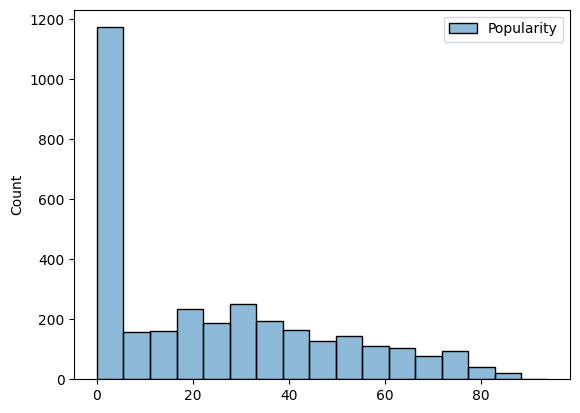

In [13]:
sns.histplot(df[df['lyrics'].isnull()][['Popularity']])
plt.show()

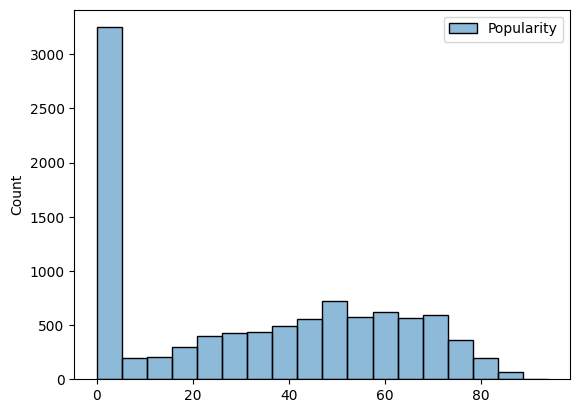

In [14]:
## Check Distribution of Popularity Among All Songs
sns.histplot(df[['Popularity']])
plt.show()

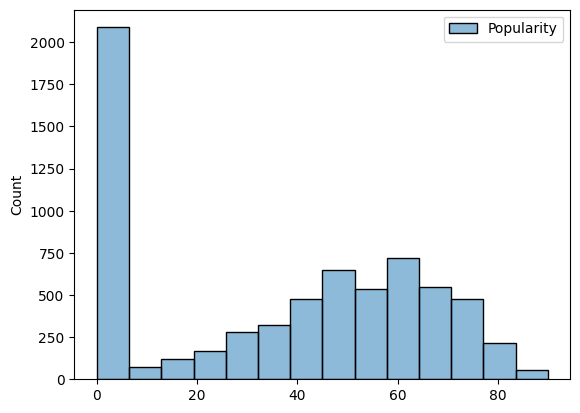

In [15]:
## Check Distribution of Popularity Among Songs with Lyrics
# Similar distribution of populariy of songs with lyrics vs all songs
sns.histplot(df[~df['lyrics'].isnull()][['Popularity']])
plt.show()

## Include Songs with Lyrics

In [16]:
spotify = df[~df['lyrics'].isnull()]
spotify['lyrics']

0        I'm in transit\n Floating, stranded on this bo...
1        Sherry, Sherry baby\n Sherry, Sherry baby\n Sh...
3        Fell from the sky\n We fell from the sky and s...
4        I never wanted, I never wanted to touch a man\...
6        I woke up with a fear this morning\n But I can...
                               ...                        
10540    In the beginning\n I never thought it would be...
10543    We'll be fighting in the streets\n With our ch...
10544    Once upon a younger year\n When all our shadow...
10548    Yeah\n I'm not that kind of guy who can take a...
10549    If you're blue, and you don't know where to go...
Name: lyrics, Length: 6722, dtype: object

In [17]:
# Drop duplicates track name
spotify.drop_duplicates(subset=['Track Name'],inplace=True)
spotify = spotify.reset_index()

/var/folders/cs/klxrwt2519s1xtvd84p769100000gn/T/ipykernel_17399/168856989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify.drop_duplicates(subset=['Track Name'],inplace=True)


In [18]:
spotify = spotify[['Track Name', 'Artist Name(s)', 'Artist Genres', 'Label', 'lyrics',
                   'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
                   'Liveness', 'Valence', 'Tempo', 'Key', 'Mode', 'Time Signature', 'Popularity', 'Track Characteristics']]
spotify = spotify.drop_duplicates()
spotify.head()

,Track Name,Artist Name(s),Artist Genres,Label,lyrics,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Key,Mode,Time Signature,Popularity,Track Characteristics
0,Fader,The Temper Trap,"indietronica,modern rock,shimmer pop",Liberation Records,"I'm in transit\n Floating, stranded on this bo...",0.532,0.760,-7.123,0.0353,0.000101,0.690000,0.0752,0.158,134.974,11.0,0.0,4.0,0,Instrumental & Pure Music
1,Sherry,Frankie Valli & The Four Seasons,"adult standards,bubblegum pop,doo-wop,lounge,n...",Rhino,"Sherry, Sherry baby\n Sherry, Sherry baby\n Sh...",0.703,0.478,-8.062,0.0441,0.626000,0.000000,0.1130,0.734,117.562,7.0,1.0,4.0,54,Acoustic & Quiet
2,Let Go for Tonight,Foxes,"electropop,metropopolis,uk pop",Sign Of The Times Records,Fell from the sky\n We fell from the sky and s...,0.543,0.808,-6.615,0.0632,0.042900,0.000002,0.3260,0.299,140.064,9.0,0.0,4.0,39,Energetic & Electric
3,The Way I Want To Touch You,Captain & Tennille,"mellow gold,soft rock,yacht rock",A&M,"I never wanted, I never wanted to touch a man\...",0.664,0.585,-7.062,0.0248,0.624000,0.000112,0.3430,0.597,111.290,0.0,0.0,4.0,35,Acoustic & Quiet
4,Your Song,Rita Ora,"dance pop,pop,uk pop",Atlantic Records UK,I woke up with a fear this morning\n But I can...,0.853,0.571,-5.845,0.0543,0.133000,0.000000,0.0564,0.958,117.991,1.0,1.0,4.0,60,Danceable & Vocal


In [19]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531 entries, 0 to 5530
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Track Name             5531 non-null   object 
 1   Artist Name(s)         5531 non-null   object 
 2   Artist Genres          5531 non-null   object 
 3   Label                  5531 non-null   object 
 4   lyrics                 5531 non-null   object 
 5   Danceability           5531 non-null   float64
 6   Energy                 5531 non-null   float64
 7   Loudness               5531 non-null   float64
 8   Speechiness            5531 non-null   float64
 9   Acousticness           5531 non-null   float64
 10  Instrumentalness       5531 non-null   float64
 11  Liveness               5531 non-null   float64
 12  Valence                5531 non-null   float64
 13  Tempo                  5531 non-null   float64
 14  Key                    5531 non-null   float64
 15  Mode

## Create Remove Stopwords Function

In [20]:
def remove_stopwords(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    filtered_tokens = []
    for word in tokens:
        if word not in stopwords.words('english'):
            filtered_tokens.append(word)
    return " ".join(filtered_tokens)

from nltk.corpus import words

# Download word list
nltk.download("words")
english_vocab = set(words.words())

def remove_non_english(text):
    return " ".join(word for word in text.split() if word in english_vocab)

[nltk_data] Downloading package words to
[nltk_data]     /Users/sirindalee/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Remove Stopwords for Artist Name and Label

In [21]:
spotify['artist_name_clean'] = spotify['Artist Name(s)'].map(lambda x: remove_stopwords(x))
spotify['label_clean'] = spotify['Label'].apply(remove_stopwords)
# spotify['lyrics'] = spotify['lyrics'].apply(remove_stopwords)

## Preprocess Artist and Label Names

In [22]:
# Format artist name by removing space so that it is unique
spotify['artist_name_clean'] = spotify['artist_name_clean'].map(lambda x: x.replace(" ", ""))

# Format label name by removing space so that it is unique
spotify['label_clean'] = spotify['label_clean'].map(lambda x: x.replace(" ", ""))

# Remove space in artist genre so that it is unique
spotify['artist_genre_clean'] = spotify['Artist Genres'].map(lambda x: x.replace(" ", ""))

# Replace comma using space for artist genre
spotify['artist_genre_clean'] = spotify['artist_genre_clean'].map(lambda x: x.replace(",", " "))

spotify.head()

,Track Name,Artist Name(s),Artist Genres,Label,lyrics,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Key,Mode,Time Signature,Popularity,Track Characteristics,artist_name_clean,label_clean,artist_genre_clean
0,Fader,The Temper Trap,"indietronica,modern rock,shimmer pop",Liberation Records,"I'm in transit\n Floating, stranded on this bo...",0.532,0.760,-7.123,0.0353,0.000101,0.690000,0.0752,0.158,134.974,11.0,0.0,4.0,0,Instrumental & Pure Music,tempertrap,liberationrecords,indietronica modernrock shimmerpop
1,Sherry,Frankie Valli & The Four Seasons,"adult standards,bubblegum pop,doo-wop,lounge,n...",Rhino,"Sherry, Sherry baby\n Sherry, Sherry baby\n Sh...",0.703,0.478,-8.062,0.0441,0.626000,0.000000,0.1130,0.734,117.562,7.0,1.0,4.0,54,Acoustic & Quiet,frankievallifourseasons,rhino,adultstandards bubblegumpop doo-wop lounge nor...
2,Let Go for Tonight,Foxes,"electropop,metropopolis,uk pop",Sign Of The Times Records,Fell from the sky\n We fell from the sky and s...,0.543,0.808,-6.615,0.0632,0.042900,0.000002,0.3260,0.299,140.064,9.0,0.0,4.0,39,Energetic & Electric,foxes,signtimesrecords,electropop metropopolis ukpop
3,The Way I Want To Touch You,Captain & Tennille,"mellow gold,soft rock,yacht rock",A&M,"I never wanted, I never wanted to touch a man\...",0.664,0.585,-7.062,0.0248,0.624000,0.000112,0.3430,0.597,111.290,0.0,0.0,4.0,35,Acoustic & Quiet,captaintennille,,mellowgold softrock yachtrock
4,Your Song,Rita Ora,"dance pop,pop,uk pop",Atlantic Records UK,I woke up with a fear this morning\n But I can...,0.853,0.571,-5.845,0.0543,0.133000,0.000000,0.0564,0.958,117.991,1.0,1.0,4.0,60,Danceable & Vocal,ritaora,atlanticrecordsuk,dancepop pop ukpop


## Extract Keywords from Lyrics

In [23]:
def get_keywords(lyrics):
    rake = Rake()
    rake.extract_keywords_from_text(lyrics)
    keywords_dict = rake.get_word_degrees()
    return list(keywords_dict.keys()) #words that co-occur together with other words


spotify['keywords_lyrics'] = spotify['lyrics'].map(lambda x : get_keywords(x))

spotify.head()

,Track Name,Artist Name(s),Artist Genres,Label,lyrics,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Key,Mode,Time Signature,Popularity,Track Characteristics,artist_name_clean,label_clean,artist_genre_clean,keywords_lyrics
0,Fader,The Temper Trap,"indietronica,modern rock,shimmer pop",Liberation Records,"I'm in transit\n Floating, stranded on this bo...",0.532,0.760,-7.123,0.0353,0.000101,0.690000,0.0752,0.158,134.974,11.0,0.0,4.0,0,Instrumental & Pure Music,tempertrap,liberationrecords,indietronica modernrock shimmerpop,"[transit, floating, stranded, boat, pledge, al..."
1,Sherry,Frankie Valli & The Four Seasons,"adult standards,bubblegum pop,doo-wop,lounge,n...",Rhino,"Sherry, Sherry baby\n Sherry, Sherry baby\n Sh...",0.703,0.478,-8.062,0.0441,0.626000,0.000000,0.1130,0.734,117.562,7.0,1.0,4.0,54,Acoustic & Quiet,frankievallifourseasons,rhino,adultstandards bubblegumpop doo-wop lounge nor...,"[sherry, baby, come, tonight, ?), twist, party..."
2,Let Go for Tonight,Foxes,"electropop,metropopolis,uk pop",Sign Of The Times Records,Fell from the sky\n We fell from the sky and s...,0.543,0.808,-6.615,0.0632,0.042900,0.000002,0.3260,0.299,140.064,9.0,0.0,4.0,39,Energetic & Electric,foxes,signtimesrecords,electropop metropopolis ukpop,"[fell, sky, started, walking, leavin, footprin..."
3,The Way I Want To Touch You,Captain & Tennille,"mellow gold,soft rock,yacht rock",A&M,"I never wanted, I never wanted to touch a man\...",0.664,0.585,-7.062,0.0248,0.624000,0.000112,0.3430,0.597,111.290,0.0,0.0,4.0,35,Acoustic & Quiet,captaintennille,,mellowgold softrock yachtrock,"[never, wanted, touch, man, way, wanna, love, ..."
4,Your Song,Rita Ora,"dance pop,pop,uk pop",Atlantic Records UK,I woke up with a fear this morning\n But I can...,0.853,0.571,-5.845,0.0543,0.133000,0.000000,0.0564,0.958,117.991,1.0,1.0,4.0,60,Danceable & Vocal,ritaora,atlanticrecordsuk,dancepop pop ukpop,"[woke, fear, morning, taste, tip, tongue, alar..."


## Remove Stopwords in Lyrics

In [24]:
spotify['keywords_lyrics_clean'] = spotify['keywords_lyrics'].astype(str)

spotify['keywords_lyrics_clean'] = spotify['keywords_lyrics_clean'].apply(remove_stopwords)

spotify['lyrics_clean'] = spotify['lyrics'].astype(str)

spotify['lyrics_clean'] = spotify['lyrics'].apply(remove_stopwords)
spotify.head()

,Track Name,Artist Name(s),Artist Genres,Label,lyrics,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Key,Mode,Time Signature,Popularity,Track Characteristics,artist_name_clean,label_clean,artist_genre_clean,keywords_lyrics,keywords_lyrics_clean,lyrics_clean
0,Fader,The Temper Trap,"indietronica,modern rock,shimmer pop",Liberation Records,"I'm in transit\n Floating, stranded on this bo...",0.532,0.760,-7.123,0.0353,0.000101,0.690000,0.0752,0.158,134.974,11.0,0.0,4.0,0,Instrumental & Pure Music,tempertrap,liberationrecords,indietronica modernrock shimmerpop,"[transit, floating, stranded, boat, pledge, al...",transit floating stranded boat pledge allegian...,im transit floating stranded boat pledge alleg...
1,Sherry,Frankie Valli & The Four Seasons,"adult standards,bubblegum pop,doo-wop,lounge,n...",Rhino,"Sherry, Sherry baby\n Sherry, Sherry baby\n Sh...",0.703,0.478,-8.062,0.0441,0.626000,0.000000,0.1130,0.734,117.562,7.0,1.0,4.0,54,Acoustic & Quiet,frankievallifourseasons,rhino,adultstandards bubblegumpop doo-wop lounge nor...,"[sherry, baby, come, tonight, ?), twist, party...",sherry baby come tonight twist party bright mo...,sherry sherry baby sherry sherry baby sherry b...
2,Let Go for Tonight,Foxes,"electropop,metropopolis,uk pop",Sign Of The Times Records,Fell from the sky\n We fell from the sky and s...,0.543,0.808,-6.615,0.0632,0.042900,0.000002,0.3260,0.299,140.064,9.0,0.0,4.0,39,Energetic & Electric,foxes,signtimesrecords,electropop metropopolis ukpop,"[fell, sky, started, walking, leavin, footprin...",fell sky started walking leavin footprints gro...,fell sky fell sky started walking leavin footp...
3,The Way I Want To Touch You,Captain & Tennille,"mellow gold,soft rock,yacht rock",A&M,"I never wanted, I never wanted to touch a man\...",0.664,0.585,-7.062,0.0248,0.624000,0.000112,0.3430,0.597,111.290,0.0,0.0,4.0,35,Acoustic & Quiet,captaintennille,,mellowgold softrock yachtrock,"[never, wanted, touch, man, way, wanna, love, ...",never wanted touch man way wan na love sunshin...,never wanted never wanted touch man way wan na...
4,Your Song,Rita Ora,"dance pop,pop,uk pop",Atlantic Records UK,I woke up with a fear this morning\n But I can...,0.853,0.571,-5.845,0.0543,0.133000,0.000000,0.0564,0.958,117.991,1.0,1.0,4.0,60,Danceable & Vocal,ritaora,atlanticrecordsuk,dancepop pop ukpop,"[woke, fear, morning, taste, tip, tongue, alar...",woke fear morning taste tip tongue alarm witho...,woke fear morning taste tip tongue alarm witho...


## Add Sentiment of Lyrics

In [25]:
spotify['sentiment'] = spotify['lyrics_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [26]:
spotify['sentiment'].describe()

count    5531.000000
mean        0.102514
std         0.198042
min        -0.850000
25%        -0.023807
50%         0.094970
75%         0.234848
max         1.000000
Name: sentiment, dtype: float64

## Combine Artist Name, Genre

In [27]:
spotify['artist_info'] = spotify['artist_name_clean'] + " " + spotify['artist_genre_clean']
spotify[['Artist Name(s)', 'Artist Genres', 'artist_name_clean', 'artist_genre_clean', 'artist_info']]

,Artist Name(s),Artist Genres,artist_name_clean,artist_genre_clean,artist_info
0,The Temper Trap,"indietronica,modern rock,shimmer pop",tempertrap,indietronica modernrock shimmerpop,tempertrap indietronica modernrock shimmerpop
1,Frankie Valli & The Four Seasons,"adult standards,bubblegum pop,doo-wop,lounge,n...",frankievallifourseasons,adultstandards bubblegumpop doo-wop lounge nor...,frankievallifourseasons adultstandards bubbleg...
2,Foxes,"electropop,metropopolis,uk pop",foxes,electropop metropopolis ukpop,foxes electropop metropopolis ukpop
3,Captain & Tennille,"mellow gold,soft rock,yacht rock",captaintennille,mellowgold softrock yachtrock,captaintennille mellowgold softrock yachtrock
4,Rita Ora,"dance pop,pop,uk pop",ritaora,dancepop pop ukpop,ritaora dancepop pop ukpop
...,...,...,...,...,...
5526,Olivia Newton-John,"adult standards,australian dance,disco,mellow ...",olivianewtonjohn,adultstandards australiandance disco mellowgol...,olivianewtonjohn adultstandards australiandanc...
5527,Alanis Morissette,"canadian pop,canadian singer-songwriter,lilith...",alanismorissette,canadianpop canadiansinger-songwriter lilith n...,alanismorissette canadianpop canadiansinger-so...
5528,The Who,"album rock,british invasion,classic rock,hard ...",,albumrock britishinvasion classicrock hardrock...,albumrock britishinvasion classicrock hardroc...
5529,New Kids On The Block,boy band,newkidsblock,boyband,newkidsblock boyband


## Label Topic of Lyrics using BERT Topic

In [28]:
# lyrics_list = list(spotify['keywords_lyrics_clean'])

# # Train BERTopic model
# topic_model = BERTopic(nr_topics = 10)

# topics, probs = topic_model.fit_transform(lyrics_list)

# # new_topic_model = topic_model.reduce_topics(lyrics_list, nr_topics=10)  # Reduce to 10 topics

# # reduced_topics = new_topic_model.transform(lyrics_list)[0]

# spotify['lyrics_topic'] = topics

In [29]:
# pd.set_option("display.max_colwidth", None)
# spotify[['lyrics', 'keywords_lyrics', 'keywords_lyrics_clean']].head()

In [30]:
# # Display topic distribution
# print(topic_model.get_topic_info())

# # Visualize topics
# topic_model.visualize_barchart()
# # spotify.head()
# # # Display topic distribution
# # topic_info = topic_model.get_topic_info()
# # import ace_tools as tools
# # tools.display_dataframe_to_user(name="BERTopic Topic Information", dataframe=topic_info)

In [31]:
# spotify['lyrics_topic'].unique()

## Vectorize Artist Info using CountVectorizer

In [32]:
count_vectorizer = CountVectorizer()
# count_matrix = count_vectorizer.fit_transform(spotify['artist_info'])
artist_info_matrix = count_vectorizer.fit_transform(spotify['artist_info'])
artist_info_matrix.shape

(5531, 3167)

In [33]:
# Convert to DataFrame for better readability
artist_info_countvectorizer = pd.DataFrame(artist_info_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())
artist_info_countvectorizer

aaliyah  aaprockyskepta  abba  abc  ablogic  acappella  acdc  acebase  \
0           0               0     0    0        0          0     0        0   
1           0               0     0    0        0          0     0        0   
2           0               0     0    0        0          0     0        0   
3           0               0     0    0        0          0     0        0   
4           0               0     0    0        0          0     0        0   
...       ...             ...   ...  ...      ...        ...   ...      ...   
5526        0               0     0    0        0          0     0        0   
5527        0               0     0    0        0          0     0        0   
5528        0               0     0    0        0          0     0        0   
5529        0               0     0    0        0          0     0        0   
5530        0               0     0    0        0          0     0        0   

      acidhouse  acidrock  acousticblues  acousticcover  acousticpop  \
0             0         0              0              0            0   
1             0         0              0              0            0   
2             0         0              0              0            0   
3             0         0              0              0            0   
4             0         0              0              0            0   
...         ...       ...            ...            ...          ...   
5526          0         0              0              0            0   
5527          0         0              0              0            0   
5528          0         0              0              0            0   
5529          0         0              0              0            0   
5530          0         0              0              0            0   

      adamants  adamlambert  adamlevine  adele  adriangurvitz  adrianlux  \
0            0            0           0      0              0          0   
1            0            0           0      0              0          0   
2            0            0           0      0              0          0   
3            0            0           0      0              0          0   
4            0            0           0      0              0          0   
...        ...          ...         ...    ...            ...        ...   
5526         0            0           0      0              0          0   
5527         0            0           0      0              0          0   
5528         0            0           0      0              0          0   
5529         0            0           0      0              0          0   
5530         0            0           0      0              0          0   

      adultstandards  aerosmith  afi  afrobeats  afrofuturism  afrojackwrabel  \
0                  0          0    0          0             0               0   
1                  1          0    0          0             0               0   
2                  0          0    0          0             0               0   
3                  0          0    0          0             0               0   
4                  0          0    0          0             0               0   
...              ...        ...  ...        ...           ...             ...   
5526               1          0    0          0             0               0   
5527               0          0    0          0             0               0   
5528               0          0    0          0             0               0   
5529               0          0    0          0             0               0   
5530               0          0    0          0             0               0   

      afroswing  agnes  aha  airsupply  ajmitchellavamax  ajr  akon  \
0             0      0    0          0                 0    0     0   
1             0      0    0          0                 0    0     0   
2             0      0    0          0                 0    0     0   
3             0      0

## Vectorize Keywords of Lyrics using TF-IDF

In [34]:
tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(spotify['artist_info'])
tfidf_lyrics_matrix = tfidf_vectorizer.fit_transform(spotify['keywords_lyrics_clean'])

tfidf_lyrics_matrix.shape

(5531, 20676)

In [35]:
# # Convert to DataFrame for better readability
# tfidf_df = pd.DataFrame(lyrics_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# # tfidf_df

## Vectorize Bag of Words using Word2Vec

In [36]:
# Tokenize bag_of_words for Word2Vec
tokenized_words = [text.split() for text in spotify['keywords_lyrics_clean']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_words, vector_size=100, window=5, min_count=1, workers=4)

# Convert lyrics into average Word2Vec vectors
def get_average_word2vec(words, model):
    valid_words = [word for word in words if word in model.wv]
    if not valid_words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in valid_words], axis=0)

spotify['word2vec_vector'] = spotify['keywords_lyrics_clean'].apply(lambda x: get_average_word2vec(x.split(), word2vec_model))

# Convert Word2Vec vectors to NumPy array
word2vec_matrix = np.vstack(spotify['word2vec_vector'].values)

In [37]:
word2vec_matrix.shape

(5531, 100)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def display_pca_scatterplot(model, words=None, sample=0):
    if words is None:
        if sample > 0:
            words = np.random.choice(list(model.wv.index_to_key), sample)  # Updated: index_to_key instead of vocab
        else:
            words = list(model.wv.index_to_key)  # Updated: index_to_key instead of vocab

    word_vectors = np.array([model.wv[w] for w in words])  # Extract vectors

    twodim = PCA(n_components=2).fit_transform(word_vectors)  # PCA to 2D

    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k', c='r')
    
    # Add labels
    for word, (x, y) in zip(words, twodim):
        plt.text(x + 0.05, y + 0.05, word)
    
    plt.title("PCA Word Embeddings Visualization")
    plt.show()  # ✅ Ensure plot is displayed

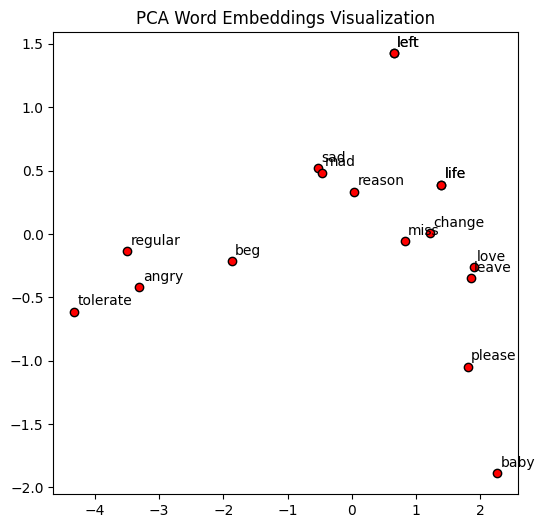

In [39]:
display_pca_scatterplot(word2vec_model,['love', 'baby', 'sad', 'life', 'tolerate', 'please', 'beg', 'reason', 'regular', 'miss', 'life', 'change', 'leave', 'left', 
                                       'mad', 'angry', 'left'])

In [40]:
# # Function to get sentence vector by averaging word vectors
# def get_lyric_vector(lyric, model):
#     words = lyric.split()  # Tokenize lyric into words
#     vectors = [model.wv[word] for word in words if word in model.wv]
#     return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# # Assuming `lyrics_data` is a list of song lyrics (one per row)
# # If using a DataFrame, replace `lyrics_data` with `df["lyrics_column_name"].tolist()`
# lyrics_vectors = np.array([get_lyric_vector(lyric, word2vec_model) for lyric in lyrics_data])

# # Convert to DataFrame
# song_vectors_df = pd.DataFrame(lyrics_vectors)

In [41]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", 10)

word2vec_df = pd.DataFrame(word2vec_matrix)
word2vec_df

,0,1,2,3,4,...,95,96,97,98,99
0,-0.186153,0.438946,-0.052807,-0.039761,0.125198,...,0.430347,0.240899,-0.519289,0.258374,-0.053406
1,-0.289493,0.703791,-0.019010,-0.069820,0.176130,...,0.698068,0.383192,-0.801798,0.251814,-0.066381
2,-0.279287,0.682219,-0.038263,-0.049104,0.168827,...,0.634252,0.364405,-0.748947,0.302874,-0.060429
3,-0.341702,0.740437,-0.123146,-0.075417,0.170025,...,0.703426,0.369166,-0.814889,0.315525,-0.042530
4,-0.253482,0.614813,-0.034070,-0.049506,0.176617,...,0.554457,0.336659,-0.673935,0.273963,-0.051212
...,...,...,...,...,...,...,...,...,...,...,...
5526,-0.237627,0.494956,-0.100759,-0.035402,0.163636,...,0.472347,0.270324,-0.611230,0.334874,-0.060975
5527,-0.153321,0.350909,-0.015483,-0.029723,0.108546,...,0.310406,0.195787,-0.376029,0.144903,-0.040177
5528,-0.180757,0.445410,-0.032933,-0.034403,0.131105,...,0.414316,0.253587,-0.516973,0.242890,-0.040957
5529,-0.296278,0.686214,-0.098551,-0.047652,0.163625,...,0.663345,0.355670,-0.768111,0.332816,-0.059985


In [42]:
scaler = StandardScaler()
word2vec_similarity_standardized = scaler.fit_transform(word2vec_matrix)

# Normalize each word vector in the Word2Vec matrix
word2vec_matrix_normalized = normalize(word2vec_matrix, norm='l2')


In [43]:
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.max_columns", 10)

word2vec_df = pd.DataFrame(word2vec_matrix_normalized)
word2vec_df

,0,1,2,3,4,...,95,96,97,98,99
0,-0.053598,0.126384,-0.015204,-0.011448,0.036048,...,0.123908,0.069361,-0.149516,0.074392,-0.015377
1,-0.058716,0.142745,-0.003856,-0.014161,0.035723,...,0.141584,0.077720,-0.162623,0.051074,-0.013464
2,-0.058283,0.142368,-0.007985,-0.010247,0.035231,...,0.132358,0.076045,-0.156293,0.063205,-0.012611
3,-0.063413,0.137410,-0.022853,-0.013996,0.031553,...,0.130541,0.068510,-0.151227,0.058555,-0.007893
4,-0.057329,0.139050,-0.007706,-0.011197,0.039945,...,0.125399,0.076141,-0.152421,0.061961,-0.011582
...,...,...,...,...,...,...,...,...,...,...,...
5526,-0.059462,0.123854,-0.025213,-0.008859,0.040947,...,0.118197,0.067644,-0.152950,0.083796,-0.015258
5527,-0.059694,0.136623,-0.006028,-0.011572,0.042262,...,0.120854,0.076228,-0.146404,0.056417,-0.015643
5528,-0.053225,0.131154,-0.009697,-0.010130,0.038605,...,0.121998,0.074670,-0.152226,0.071521,-0.012060
5529,-0.056243,0.130266,-0.018708,-0.009046,0.031061,...,0.125924,0.067518,-0.145812,0.063179,-0.011387


## BERT Embedding

In [44]:
from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer("all-MiniLM-L6-v2")

bert_embedding_matrix = np.array([bert_model.encode(lyrics) for lyrics in spotify["keywords_lyrics_clean"]])

In [45]:
bert_embedding_matrix.shape

(5531, 384)

In [46]:
pd.set_option("display.max_colwidth", 50)
pd.set_option("display.max_columns", 10)

bert_df = pd.DataFrame(bert_embedding_matrix)
bert_df

,0,1,2,3,4,...,379,380,381,382,383
0,-0.006774,-0.051937,0.062708,-0.001512,0.052102,...,-0.005658,0.032090,-0.010281,-0.007009,-0.005329
1,-0.075876,-0.031299,0.055969,0.020134,-0.048129,...,0.046712,0.003198,0.080382,-0.019965,-0.104067
2,-0.041455,-0.085146,0.087218,0.009781,0.049352,...,0.038653,0.033622,-0.036462,-0.026269,0.007393
3,-0.087284,0.006863,0.077970,0.048862,0.009378,...,-0.030187,0.106418,0.028516,-0.052849,0.021415
4,-0.021077,-0.051282,0.038390,0.060887,0.028547,...,0.029120,0.041625,0.029327,-0.007715,-0.084739
...,...,...,...,...,...,...,...,...,...,...,...
5526,-0.026670,-0.039442,-0.018629,0.015092,-0.008629,...,-0.013314,0.046375,0.008684,-0.038554,-0.015159
5527,-0.018773,0.021080,0.019311,0.007747,0.035917,...,0.003651,0.107160,-0.002362,0.050047,0.055357
5528,-0.008873,0.051540,-0.022936,0.002498,-0.024291,...,-0.003787,0.048069,-0.051757,0.008707,-0.043163
5529,-0.078631,-0.050005,0.107541,0.051721,0.024217,...,-0.057873,0.055417,-0.066109,0.025904,-0.009667


## Transform Audio Features, Popularity, and Lyrics Sentiment

In [47]:
audio_features = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness','Liveness', 'Valence', 'Tempo', 'Key', 'Mode', 'Time Signature', 'Popularity', 'sentiment']

scaler = StandardScaler()

audio_features_matrix = scaler.fit_transform(spotify[audio_features])

In [48]:
# Create dummy variables for track characteristics  
track_characteristics = pd.get_dummies(spotify['Track Characteristics']).astype(int)
audio_features_matrix = np.hstack([audio_features_matrix, track_characteristics])
audio_features_matrix

array([[-0.50687545,  0.41393608,  0.07033693, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.67070139, -1.05524622, -0.21930871, ...,  0.        ,
         0.        ,  0.        ],
       [-0.43112489,  0.66400966,  0.22703553, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.55363235,  1.24751469,  0.34548487, ...,  0.        ,
         1.        ,  0.        ],
       [-0.05925852, -2.07638002, -3.04728659, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.32491074, -2.02428136, -3.0108881 , ...,  0.        ,
         0.        ,  0.        ]])

In [49]:
# Convert NumPy arrays back to DataFrame for verification
audio_df = pd.DataFrame(audio_features_matrix)
audio_df.head(5)

,0,1,2,3,4,...,13,14,15,16,17
0,-0.506875,0.413936,0.070337,-0.481140,-0.852900,...,-0.444998,0.0,0.0,0.0,1.0
1,0.670701,-1.055246,-0.219309,-0.330851,1.642602,...,1.600181,1.0,0.0,0.0,0.0
2,-0.431125,0.664010,0.227036,-0.004656,-0.682258,...,0.997284,0.0,0.0,1.0,0.0
3,0.402131,-0.497791,0.089153,-0.660462,1.634627,...,-0.503123,1.0,0.0,0.0,0.0
4,1.703664,-0.570729,0.464551,-0.156653,-0.323023,...,0.833790,0.0,1.0,0.0,0.0


## Compute Cosine Similarity Score

In [50]:
# def compute_audio_similarity(df, feature_cols):
#     audio_matrix = df[feature_cols].values
#     audio_sim = np.zeros((len(audio_matrix), len(audio_matrix)))

#     for i in range(len(audio_matrix)):
#         for j in range(len(audio_matrix)):
#             audio_sim[i][j] = 1 / (1 + euclidean(audio_matrix[i], audio_matrix[j]))  # Convert distance to similarity

#     return audio_sim

# # audio_similarity = compute_audio_similarity(spotify, audio_features)

In [51]:
# final_count_matrix = hstack([count_matrix, audio_features_scaled])
# final_tfidf_matrix = hstack([tfidf_matrix, audio_features_scaled])
# final_word2vec_matrix = hstack([word2vec_matrix, audio_features_scaled])

# count_similarity = cosine_similarity(final_count_matrix)
# tfidf_similarity = cosine_similarity(final_tfidf_matrix)
# # word2vec_similarity = cosine_similarity(final_word2vec_matrix)

artist_info_similarity = cosine_similarity(artist_info_matrix)
lyrics_similarity_word2vec = cosine_similarity(word2vec_matrix)
lyrics_similarity_tfidf = cosine_similarity(tfidf_lyrics_matrix)
lyrics_similarity_bert = cosine_similarity(bert_embedding_matrix)

audio_sentiment_popularity_similarity = cosine_similarity(audio_features_matrix)

In [52]:
artist_info_similarity.shape

(5531, 5531)

In [53]:
audio_sentiment_popularity_similarity = (audio_sentiment_popularity_similarity + 1) / 2
# lyrics_similarity = (lyrics_similarity + 1) / 2
lyrics_similarity_bert = (lyrics_similarity_bert + 1) / 2

In [54]:

np.min(lyrics_similarity_bert), np.max(lyrics_similarity_bert)

(0.43059483, 1.0000004)

In [55]:
lyrics_similarity_bert.mean(), audio_sentiment_popularity_similarity.mean(), artist_info_similarity.mean()

(0.70886165, 0.5167928153347123, 0.04795709207441669)

In [56]:
# Assign weights for different types of similarity
final_similarity = 0.10 * artist_info_similarity + 0.25 * lyrics_similarity_bert + 0.65 * audio_sentiment_popularity_similarity

In [57]:
def show_lyrics_similarity(song_index, df, top_n ):
    lyrics_scores = list(enumerate(lyrics_similarity_bert[song_index]))
    sorted_lyrics_scores = sorted(lyrics_scores, key= lambda x: x[1], reverse = True)[1: top_n+1]

    song_indices = [i[0] for i in sorted_lyrics_scores]
    
    track_name_values = df.iloc[song_indices]['Track Name'].values
    artist_name_values = df.iloc[song_indices]['Artist Name(s)'].values
    song_lyrics_values = df.iloc[song_indices]['lyrics'].values

    result = pd.DataFrame({'track_name': track_name_values, 
                           'artist_name': artist_name_values, 
                           'song_lyrics': song_lyrics_values})
    return result

song_index_lyrics = spotify[spotify['Track Name'] == 'You Belong With Me'].index[0]

pd.set_option("display.max_colwidth", 10000)
show_lyrics_similarity(song_index_lyrics, spotify, top_n = 5)

track_name        artist_name  \
0                       Centerfold  The J. Geils Band   
1                      Begin Again       Taylor Swift   
2  Don't Stop (Color on the Walls)  Foster The People   
3      Dirty Deeds Done Dirt Cheap              AC/DC   
4                          Hold Up            Beyoncé   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Song Recommendation

In [58]:
# Function to recommend similar songs and show individual similarity scores
def recommend_songs(song_index, df, final_similarity, top_n=8):
    # Compute similarity scores for each feature
    artist_scores = list(enumerate(artist_info_similarity[song_index]))
    lyrics_scores = list(enumerate(lyrics_similarity_bert[song_index]))
    audio_scores = list(enumerate(audio_sentiment_popularity_similarity[song_index]))
    final_scores = list(enumerate(final_similarity[song_index]))

    # Sort final similarity scores in descending order
    final_scores = sorted(final_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # Extract recommended song indices
    recommended_indices = [i[0] for i in final_scores]

    # Extract individual similarity scores
    artist_sim_values = [artist_scores[i][1] for i in recommended_indices]
    lyrics_sim_values = [lyrics_scores[i][1] for i in recommended_indices]
    audio_sim_values = [audio_scores[i][1] for i in recommended_indices]
    final_sim_values = [i[1] for i in final_scores]

    # Extract song details
    recommended_songs = df.iloc[recommended_indices]['Track Name'].values
    recommended_artist = df.iloc[recommended_indices]['Artist Name(s)'].values
    recommended_artist_genre = df.iloc[recommended_indices]['Artist Genres'].values
    recommended_sentiment = df.iloc[recommended_indices]['sentiment'].values
    recommended_popularity = df.iloc[recommended_indices]['Popularity'].values

    # Create DataFrame with similarity scores
    recommendation_result = pd.DataFrame({
        'Recommended Songs': recommended_songs,
        'Artist Name(s)': recommended_artist,
        'Artist Genres': recommended_artist_genre,
        # 'Sentiment': recommended_sentiment,
        # 'Popularity': recommended_popularity,
        'Artist Similarity': artist_sim_values,
        'Lyrics Similarity': lyrics_sim_values,
        'Audio Similarity': audio_sim_values,
        'Final Similarity': final_sim_values
    })

    return recommendation_result

# Get song index
song_index = spotify[spotify['Track Name'] == "Fast Car"].index[0]

# Test Recommendation (Find similar songs to song at index 0)
recommend_songs(song_index, spotify, final_similarity, top_n=8)

,Recommended Songs,Artist Name(s),Artist Genres,Artist Similarity,Lyrics Similarity,Audio Similarity,Final Similarity
0,I Can't Make You Love Me,Bonnie Raitt,"country rock,electric blues,folk,folk rock,mellow gold,singer-songwriter,soft rock",0.377964,0.692354,0.927467,0.813738
1,Do You Really Want To Hurt Me,Culture Club,"new romantic,new wave,new wave pop,soft rock,synthpop",0.000000,0.735582,0.967086,0.812501
2,50 Ways to Leave Your Lover,Paul Simon,"classic rock,folk,folk rock,mellow gold,permanent wave,rock,singer-songwriter,soft rock",0.358569,0.774192,0.889007,0.807260
3,Fire and Rain - 2019 Remaster,James Taylor,"classic rock,folk,folk rock,mellow gold,singer-songwriter,soft rock",0.400892,0.762920,0.884904,0.806006
4,Bloodstream,Ed Sheeran,"pop,singer-songwriter pop,uk pop",0.169031,0.725135,0.930705,0.803145
5,Carolina in My Mind,James Taylor,"classic rock,folk,folk rock,mellow gold,singer-songwriter,soft rock",0.400892,0.736410,0.888739,0.801872
6,Baby Can I Hold You,Tracy Chapman,"folk,lilith,singer-songwriter,women's music",1.000000,0.608349,0.833887,0.794114
7,Walk On the Wild Side,Lou Reed,"classic rock,glam rock,permanent wave,rock,singer-songwriter",0.285714,0.786005,0.868282,0.789456


In [59]:
song_index = spotify[spotify['Track Name'] == "You Belong With Me"].index[0]

# Test Recommendation (Find similar songs to song at index 0)
recommend_songs(song_index, spotify, final_similarity, top_n=8)

,Recommended Songs,Artist Name(s),Artist Genres,Artist Similarity,Lyrics Similarity,Audio Similarity,Final Similarity
0,Love Story,Taylor Swift,pop,1.000000,0.777060,0.830689,0.834213
1,Love Lies (with Normani),"Khalid, Normani","pop,pop r&b,pop,r&b",0.577350,0.756377,0.887737,0.823858
2,Goodbye,Spice Girls,"dance pop,girl group,pop",0.353553,0.738096,0.923471,0.820135
3,Thumbs,Sabrina Carpenter,pop,0.500000,0.725886,0.902361,0.818006
4,Just the Way You Are,Bruno Mars,"dance pop,pop",0.408248,0.704453,0.923707,0.817348
5,Adventure of a Lifetime,Coldplay,"permanent wave,pop",0.408248,0.726188,0.905797,0.811140
6,The Other Side,Jason Derulo,"dance pop,pop",0.408248,0.790712,0.880625,0.810909
7,50 Ways to Say Goodbye,Train,"dance pop,neo mellow,pop,pop rock",0.316228,0.822100,0.878264,0.808019


In [60]:
song_index = spotify[spotify['Track Name'] == "When I Was Your Man"].index[0]

# Test Recommendation (Find similar songs to song at index 0)
recommend_songs(song_index, spotify, final_similarity, top_n=8)

,Recommended Songs,Artist Name(s),Artist Genres,Artist Similarity,Lyrics Similarity,Audio Similarity,Final Similarity
0,Count on Me,Bruno Mars,"dance pop,pop",1.000000,0.740722,0.956688,0.907028
1,"I'm Not a Girl, Not Yet a Woman",Britney Spears,"dance pop,pop",0.666667,0.748794,0.946925,0.869366
2,Frozen,Madonna,"dance pop,pop",0.666667,0.772427,0.925558,0.861386
3,Everytime,Britney Spears,"dance pop,pop",0.666667,0.807453,0.896579,0.851306
4,Too Good At Goodbyes,Sam Smith,"pop,uk pop",0.333333,0.814065,0.943483,0.850114
5,Dancing On My Own,Calum Scott,pop,0.408248,0.741483,0.959656,0.849972
6,Nothing Like Us,Justin Bieber,"canadian pop,pop",0.333333,0.827766,0.937113,0.849398
7,Happier,Ed Sheeran,"pop,singer-songwriter pop,uk pop",0.258199,0.794072,0.958930,0.847643


### KNN model

In [61]:
from sklearn.neighbors import NearestNeighbors

# scaler_lyrics = StandardScaler()
scaler_artist = StandardScaler()

# lyrics_matrix = scaler_lyrics.fit_transform(word2vec_matrix)
# artist_matrix = scaler_artist.fit_transform(artist_info_matrix)

final_feature_matrix = hstack([audio_features_matrix, word2vec_similarity_standardized, artist_info_matrix])



In [62]:
knn = NearestNeighbors(n_neighbors=8, metric="cosine")
knn.fit(final_feature_matrix)  # `final_feature_matrix` = scaled audio + lyrics + artist embeddings

# ✅ Step 2: Function to Recommend Songs Using KNN
def recommend_songs_knn(song_name, df, knn_model, feature_matrix, top_n=8):
    # ✅ Get the index of the song
    song_index = df[df['Track Name'] == song_name].index[0]

    # ✅ Find the nearest neighbors (excluding itself)
    dense_feature_matrix = feature_matrix.toarray()  # Converts sparse matrix to NumPy array

    distances, indices = knn_model.kneighbors(dense_feature_matrix[song_index].reshape(1, -1), n_neighbors=top_n+1)
    
    # Extract recommended song indices (excluding the input song itself)
    recommended_indices = indices.flatten()[1:]  
    recommended_distances = distances.flatten()[1:]

    # Extract song details
    recommended_songs = df.iloc[recommended_indices]['Track Name'].values
    recommended_artist = df.iloc[recommended_indices]['Artist Name(s)'].values
    recommended_artist_genre = df.iloc[recommended_indices]['Artist Genres'].values

    # Create DataFrame with recommendations
    recommendation_result = pd.DataFrame({
        'Recommended Songs': recommended_songs,
        'Artist Name(s)': recommended_artist,
        'Artist Genres': recommended_artist_genre,
        'Distance (Similarity)': 1 - recommended_distances  # Convert cosine distance to similarity
    })

    return recommendation_result

# ✅ Example: Recommend Similar Songs for "Fast Car"
recommend_songs_knn("Fast Car", spotify, knn, final_feature_matrix, top_n=8)

,Recommended Songs,Artist Name(s),Artist Genres,Distance (Similarity)
0,Put Your Records On,Ritt Momney,bedroom pop,0.602021
1,Bloodstream,Ed Sheeran,"pop,singer-songwriter pop,uk pop",0.584850
2,Carolina in My Mind,James Taylor,"classic rock,folk,folk rock,mellow gold,singer-songwriter,soft rock",0.559080
3,Fire and Rain - 2019 Remaster,James Taylor,"classic rock,folk,folk rock,mellow gold,singer-songwriter,soft rock",0.541337
4,Arcade,Duncan Laurence,dutch pop,0.525360
5,Don't Cry Daddy,Elvis Presley,"rock-and-roll,rockabilly",0.518213
6,Living Next Door to Alice,Smokie,missing genres,0.513258
7,Sundown,Gordon Lightfoot,"canadian country,canadian singer-songwriter,classic rock,country rock,folk,folk rock,mellow gold,singer-songwriter,soft rock",0.513077


In [63]:
recommend_songs_knn("When I Was Your Man", spotify, knn, final_feature_matrix, top_n=8)

,Recommended Songs,Artist Name(s),Artist Genres,Distance (Similarity)
0,Happier,Ed Sheeran,"pop,singer-songwriter pop,uk pop",0.824030
1,Count on Me,Bruno Mars,"dance pop,pop",0.813158
2,The Day You Went Away,Wendy Matthews,australian rock,0.780648
3,Hey There Delilah,Plain White T's,"modern rock,neo mellow,neon pop punk,pop punk,pop rock",0.770720
4,Everytime,Britney Spears,"dance pop,pop",0.745271
5,Sad,Maroon 5,pop,0.727583
6,The Most Beautiful Girl,Charlie Rich,"arkansas country,country,nashville sound",0.720894
7,Skin,Sabrina Carpenter,pop,0.715457


### Model evaluation

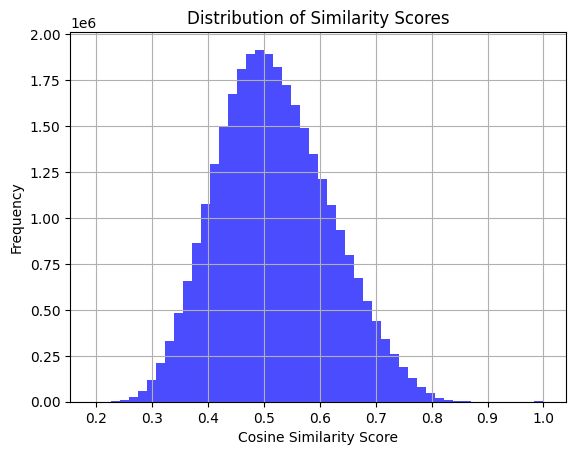

In [64]:
plt.hist(final_similarity.flatten(), bins=50, alpha=0.7, color='blue')
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.grid(True)
plt.show()

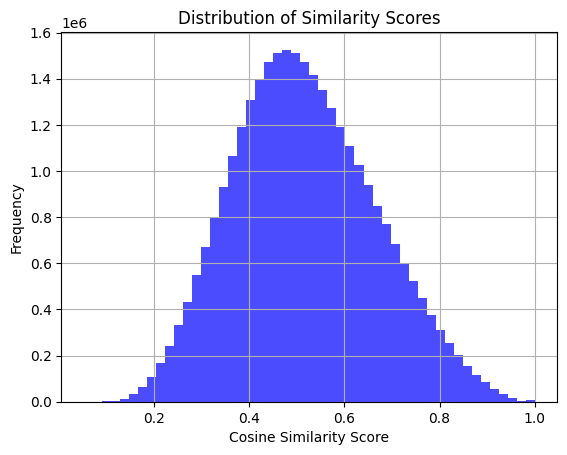

In [65]:

plt.hist(audio_sentiment_popularity_similarity.flatten(), bins=50, alpha=0.7, color='blue')
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.grid(True)
plt.show()

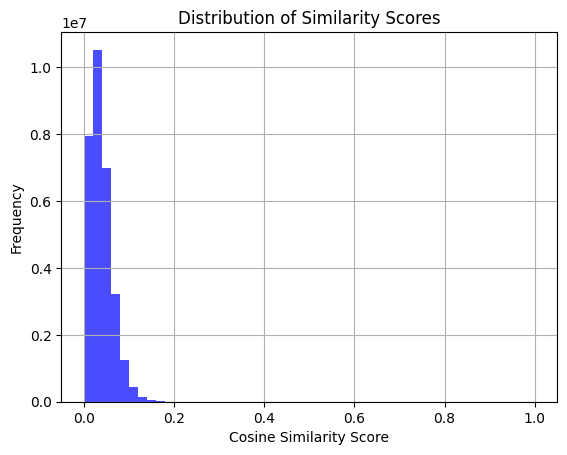

In [66]:
plt.hist(lyrics_similarity_tfidf.flatten(), bins=50, alpha=0.7, color='blue')
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.grid(True)
plt.show()

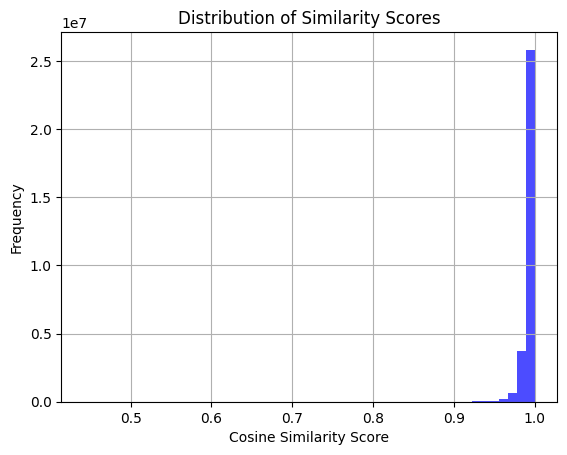

In [67]:
plt.hist(lyrics_similarity_word2vec.flatten(), bins=50, alpha=0.7, color='blue')
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.grid(True)
plt.show()

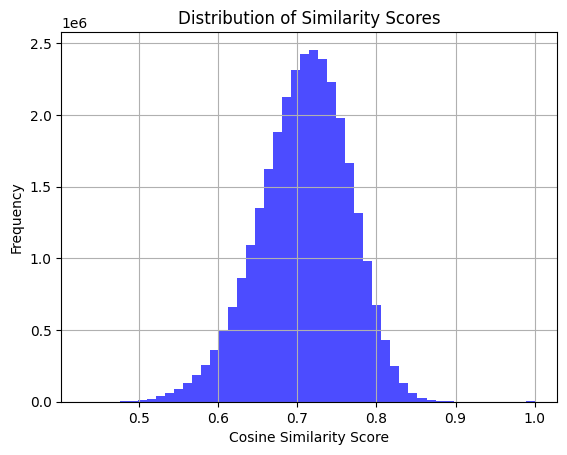

In [68]:
plt.hist(lyrics_similarity_bert.flatten(), bins=50, alpha=0.7, color='blue')
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.grid(True)
plt.show()

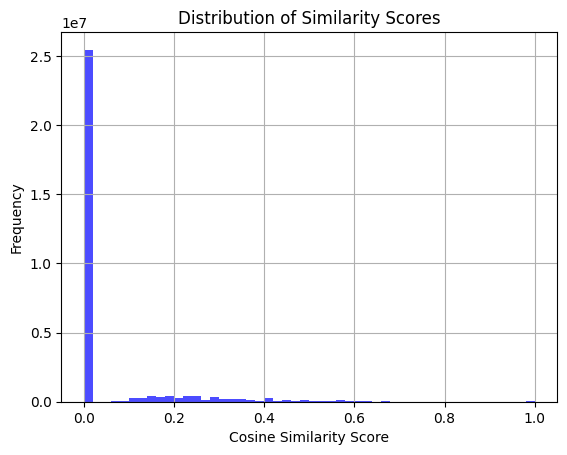

In [69]:
plt.hist(artist_info_similarity.flatten(), bins=50, alpha=0.7, color='blue')
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.grid(True)
plt.show()